In [1]:
import pandas as pd
import numpy as np

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
# demo = "../data/raw/df_final_demo.txt"
# webdata1 = "../data/raw/df_final_web_data_pt_1.txt"
# webdata2 = "../data/raw/df_final_web_data_pt_2.txt"
# experiment = "../data/raw/df_final_experiment_clients.txt"

# df_demo = pd.read_csv(demo)
# df_webdata1 = pd.read_csv(webdata1)
# df_webdata2 = pd.read_csv(webdata2)
# df_exp = pd.read_csv(experiment)

In [3]:
df_demo = pd.read_csv('/Users/sashacrowe/codebase-ih/vanguard-ab-test/data/raw/df_final_demo.txt')

## First Look at the Dataset

In [4]:
df_demo.head()

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0


In [5]:
df_demo.shape

(70609, 9)

In [5]:
df_demo.dtypes

client_id             int64
clnt_tenure_yr      float64
clnt_tenure_mnth    float64
clnt_age            float64
gendr                object
num_accts           float64
bal                 float64
calls_6_mnth        float64
logons_6_mnth       float64
dtype: object

**DATA BREAKDOWN**    
Column names are fine -> nothing to change here:
- client_id (int64) -> unique number series
- clnt_tenure_yr (float64) -> how long the client has been tenured in yrs
- clnt_tenure_mnth (float64) -> how long the client has been tenured in mnths **exactly, so more than yrs!!!**
- clnt_age (float64) -> age of client -> **....WHY is it float? There are half years**
- gendr (object: string) -> gender of client, categorial more than 2 options it seems
- num_accts (float64) -> the number of accounts the client has
- bal (float64) -> client balance
- calls_6_mnth (float64) -> Records the number of times the client reached out over a call in the past six months
- logons_6_mnth (float64) -> how many times the client has logged on in the last 6 months?

In [6]:
# Checking for missing data
df_demo.isnull().sum().sort_values(ascending=False)

clnt_age            15
clnt_tenure_yr      14
clnt_tenure_mnth    14
gendr               14
num_accts           14
bal                 14
calls_6_mnth        14
logons_6_mnth       14
client_id            0
dtype: int64

In [15]:
df_demo['gendr'].unique()

array(['U', 'M', 'F', nan, 'X'], dtype=object)

In [7]:
# checking out the null rows

null_rows = df_demo[df_demo.isnull().any(axis=1)]
print(null_rows)

       client_id  clnt_tenure_yr  clnt_tenure_mnth  clnt_age gendr  num_accts  \
4164     7402828             NaN               NaN       NaN   NaN        NaN   
8316      355337             NaN               NaN       NaN   NaN        NaN   
8677     8412164             NaN               NaN       NaN   NaN        NaN   
9583     4666211             8.0             106.0       NaN     F        2.0   
13444    2222915             NaN               NaN       NaN   NaN        NaN   
18066    4876926             NaN               NaN       NaN   NaN        NaN   
25961    5277910             NaN               NaN       NaN   NaN        NaN   
28432    7616759             NaN               NaN       NaN   NaN        NaN   
35323    8191345             NaN               NaN       NaN   NaN        NaN   
43518    1227228             NaN               NaN       NaN   NaN        NaN   
46076    8611797             NaN               NaN       NaN   NaN        NaN   
47189    5144725            

In [12]:
#percent null
(14/df_demo.shape[0])*100

0.01982750074353128

In [8]:
# drop it like it's hot
#clean_ /df_demo = df_demo.dropna()

In [9]:
df_demo.describe().round(2)

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,num_accts,bal,calls_6_mnth,logons_6_mnth
count,70609.00,70595.00,70595.00,70594.00,70595.00,70595.00,70595.00,70595.00
mean,5004991.88,12.05,150.66,46.44,2.26,147445.24,3.38,5.57
std,2877277.63,6.87,82.09,15.59,0.53,301508.71,2.24,2.35
min,169.00,2.00,33.00,13.50,1.00,13789.42,0.00,1.00
25%,2519329.00,6.00,82.00,32.50,2.00,37346.84,1.00,4.00
50%,5016978.00,11.00,136.00,47.00,2.00,63332.90,3.00,5.00
75%,7483085.00,16.00,192.00,59.00,2.00,137544.90,6.00,7.00
max,9999839.00,62.00,749.00,96.00,8.00,16320040.15,7.00,9.00


## What needs cleaning
- there are 14 clients we can drop cause their entire col rows are blank (affects less than 1% of the dataset)
- only one client is missing an age, but we can fill that with avg age
- clnt_age -> **suggest to round down cause half years are meaningless**
- num_accts, clnt_tenure_yr, logons_6_mnth & calls_6_mnth should be full integers (cause discrete values) -> **suggest to round these up**
- gendr has U & X as well as M & F -> **suggest to leave alone** alt X could be replace with U if we need to clean up something
- **we should not drop anything until we merge/join the tables together**

In [67]:
df_demo['gendr'].value_counts()

gendr
U    24122
M    23724
F    22746
X        3
Name: count, dtype: int64

## Client Profiles
- Using k-means clustering as a way of identifying client profiles
- Used the df_demo data as we want to focus on client traits and NOT behavior

In [4]:
from sklearn.cluster import KMeans

In [50]:
km = KMeans(3)

In [74]:
# feats mean client features & we had to dropna here cause kmeans doesn't work if there are nulls
# & we had to play around with the bal column as the og numbers' scale doesn't align so well with the other variables

In [81]:
feats = df_demo[['clnt_tenure_yr','clnt_age','bal']].dropna()
feats['bal'] = np.log(feats['bal'])*5

In [82]:
clusters = km.fit_predict(feats)

In [83]:
km.cluster_centers_

array([[14.96466465, 64.93056082, 58.581124  ],
       [12.29469308, 48.20571452, 56.56243539],
       [ 9.35137085, 29.06246994, 54.25250606]])

In [84]:
bal_a = round(np.exp(58.58/5),2)
bal_b = round(np.exp(56.56/5),2)
bal_c = round(np.exp(54.25/5),2)
print(f"Balance for cluster A is: {bal_a}\nBalance for cluster B is: {bal_b}\nBalance for cluster C is: {bal_c}")

Balance for cluster A is: 122516.38
Balance for cluster B is: 81797.34
Balance for cluster C is: 51534.15


<Axes: >

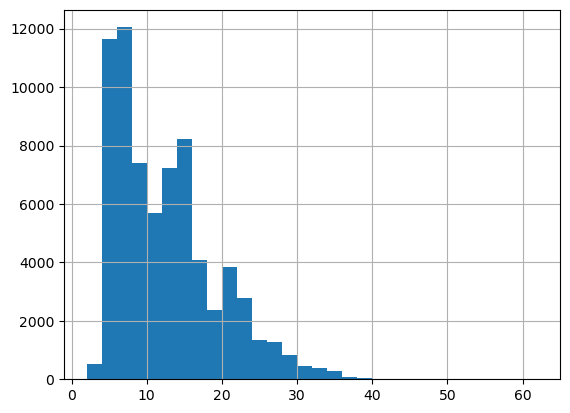

In [78]:
df_demo['clnt_tenure_yr'].hist(bins=30)

<Axes: >

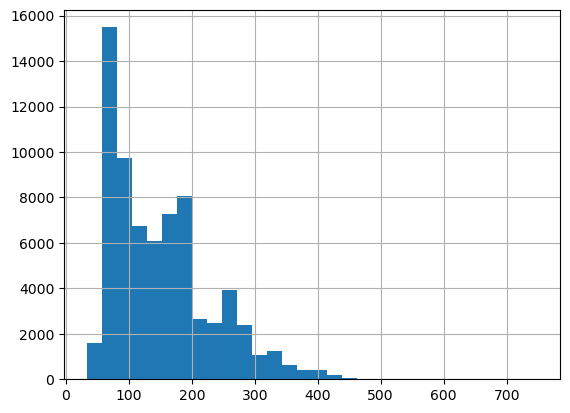

In [39]:
df_demo['clnt_tenure_mnth'].hist(bins=30)

<Axes: >

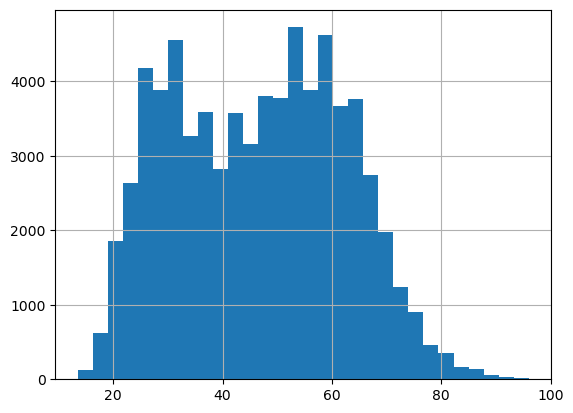

In [40]:
df_demo['clnt_age'].hist(bins=30)

<Axes: >

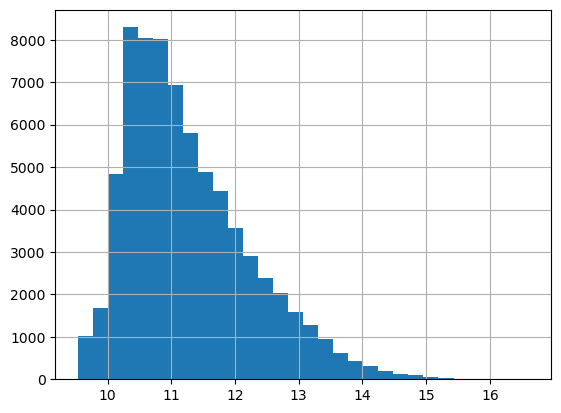

In [43]:
np.log(df_demo['bal']).hist(bins=30)

<Axes: >

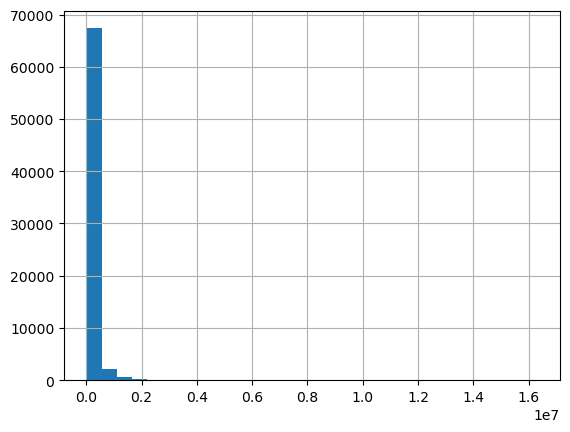

In [66]:
df_demo['bal'].hist(bins=30)

<Axes: xlabel='clnt_age', ylabel='Count'>

/opt/anaconda3/envs/notebook/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/anaconda3/envs/notebook/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


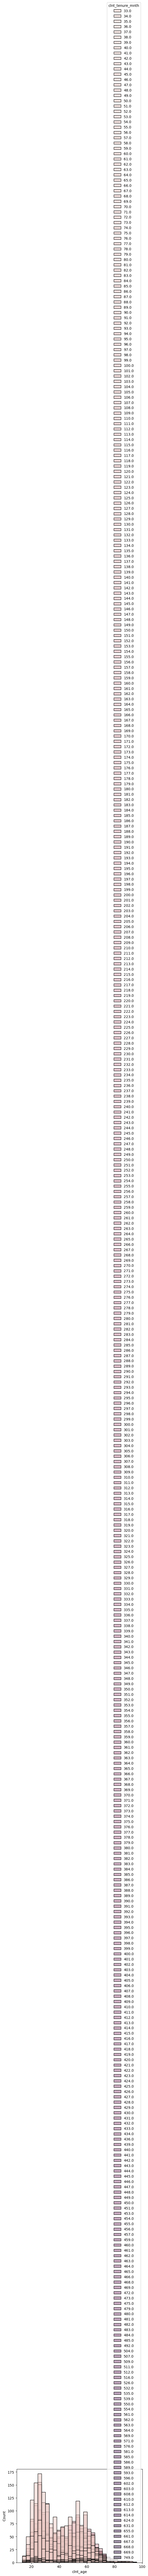

In [77]:
sns.histplot(data=df_demo, x='clnt_age', hue='clnt_tenure_mnth', kde=False, bins=30)

In [17]:
import seaborn as sns

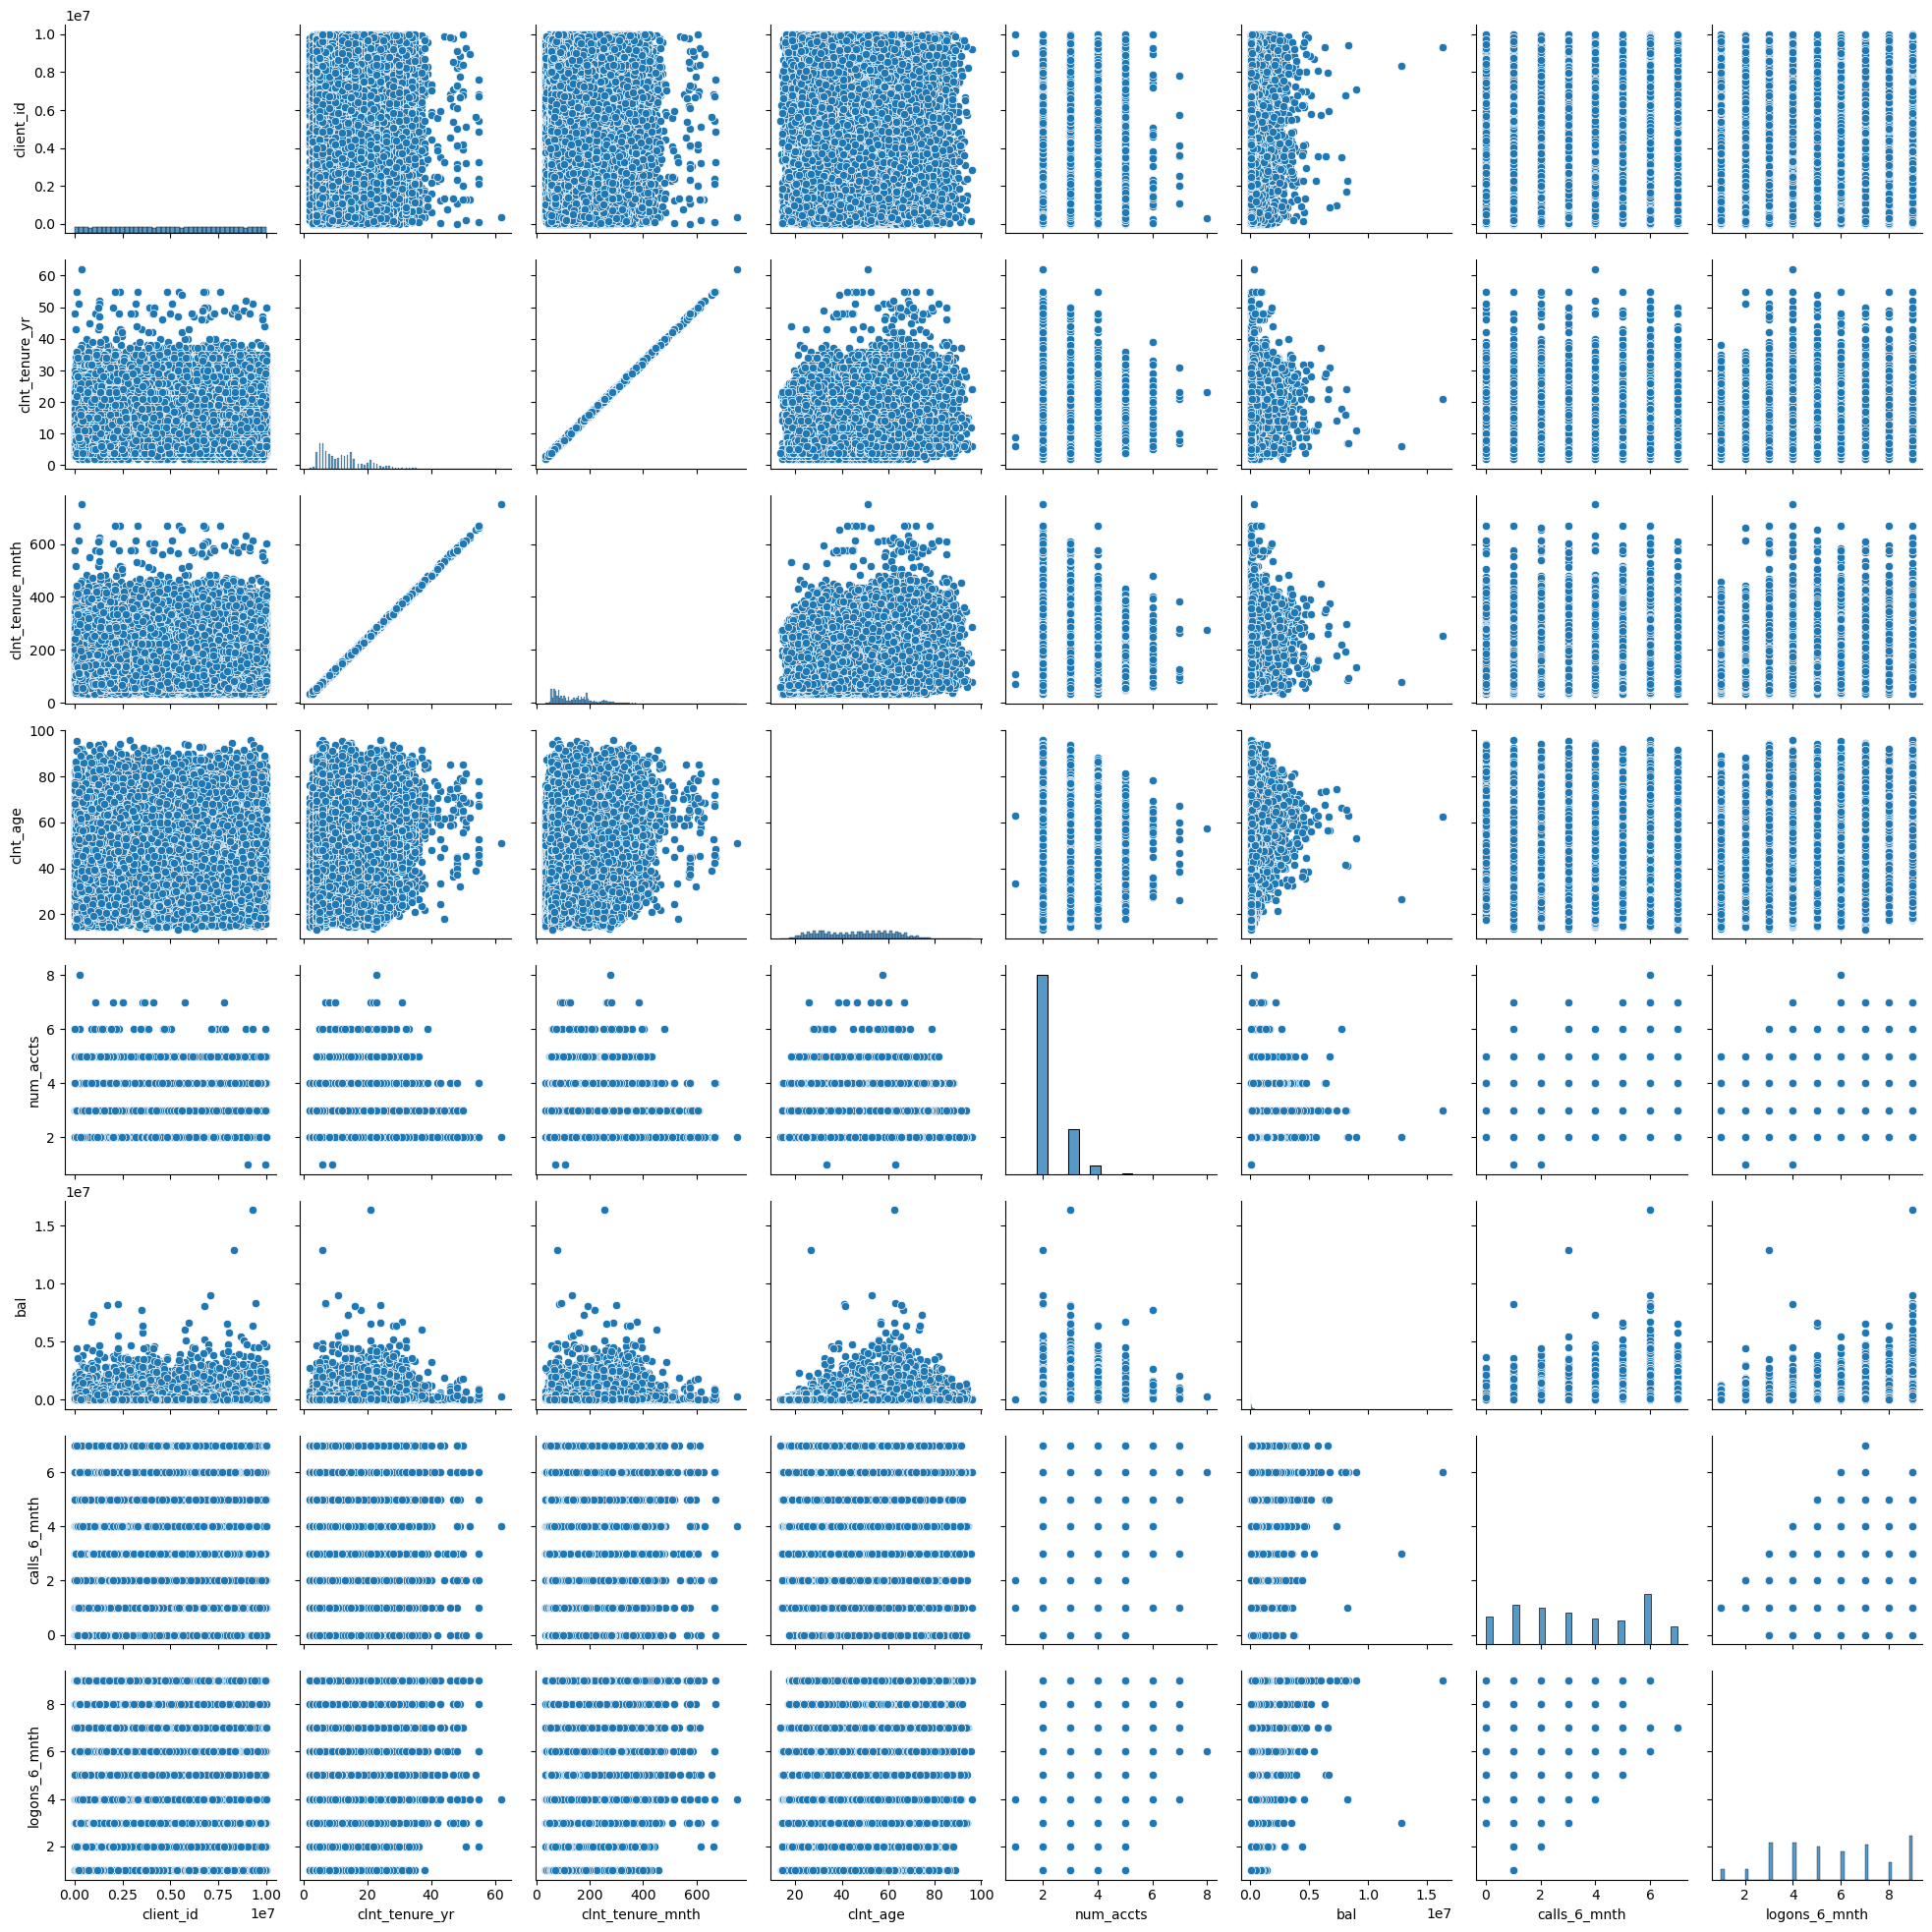

In [62]:
sns.pairplot(df_demo)

## Attempt to merge this with the ex_roster dataset


In [4]:
df_exp = pd.read_csv('/Users/sashacrowe/codebase-ih/vanguard-ab-test/data/raw/df_final_experiment_clients.txt')

In [18]:
df_exp.head()

,client_id,Variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control


In [9]:
df_merged = pd.merge(df_demo, df_exp, on='client_id', how='outer')

In [13]:
df_merged.head()

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,variation
0,169,21.0,262.0,47.5,M,2.0,501570.72,4.0,4.0,NaN
1,555,3.0,46.0,29.5,U,2.0,25454.66,2.0,6.0,Test
2,647,12.0,151.0,57.5,M,2.0,30525.80,0.0,4.0,Test
3,722,11.0,143.0,59.5,F,2.0,22466.17,1.0,1.0,NaN
4,934,9.0,109.0,51.0,F,2.0,32522.88,0.0,3.0,Test


In [11]:
df_merged.shape

(70609, 10)

In [12]:
# fixed the variation col name
# df_merged = df_merged.rename(columns={'Variation': 'variation'})

In [22]:
# fill client_id 9583's clnt_age with avg age
df_merged.loc[df_merged['client_id'] == 4666211, 'clnt_age'] = df_merged['clnt_age'].mean().round()

In [ ]:
# filling NaN values in variation with 'Untested'
#df_merged['variation'] = df_merged['variation'].fillna('Untested')

## Random Questions

In [14]:
df_merged['num_accts'].value_counts().(ascending=False)

num_accts
2.0    55497
3.0    12529
4.0     2241
5.0      284
6.0       33
7.0        8
1.0        2
8.0        1
Name: count, dtype: int64

In [73]:
bal_max = round(df_demo['bal'].max(),2)
bal_min = round(df_demo['bal'].min(),2)
print(f"The max balance amount is: {bal_max}\nThe min balance amount is: {bal_min}") 

The max balance amount is: 16320040.15
The min balance amount is: 13789.42
